<a href="https://colab.research.google.com/github/behnaznikkhah/Project/blob/master/CovidDataClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CovidDataClassification.py

# Sai Madhuri Yerramsetti
# November 10, 2020
# Student Number: 0677671

# import required packages
import pandas as pd
import numpy as np
import os
import nltk
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import randint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
from keras import Sequential, optimizers, regularizers
# This is required if nltk related words corpus is not downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# To disable warnings which arise from chained assignment
pd.options.mode.chained_assignment = None

# This is the function which combines all the headlines for each date
def combine_news_strings(news_file_path):

    #initialize the variables
    merged_news = []

    # Read the file
    corona_news = pd.read_csv(news_file_path)

    # Check for the datatypes information
    print("Info of the corona news data: \n", corona_news.info(verbose=True))

    # Convert the Date column to datetime type, sort the values and check for any null values
    corona_news['Date'] = pd.to_datetime(corona_news['Date'], format='%Y%m%d')
    corona_news.sort_values(by='Date')
    print("Corona news data before combining strings: \n", corona_news.head(5))
    print("Number of missing values: ", corona_news.isnull().sum())

    # Join the news strings datewise, drop the duplicate date rows and reset the index
    corona_news['News'] = corona_news.groupby(['Date'])['News'].transform(lambda x : ' '.join(x))   
    corona_news = corona_news.drop_duplicates(subset = ['Date'])
    corona_news = corona_news.reset_index(drop=True)

    print("Corona news data after combining headlines strings: \n", corona_news.head(5))

    # Return the new data
    return corona_news
    
# Function to search for the abbreviations in headlines and return them 
def search_abbreviation(text):
    abbreviations = []
    for i in re.finditer(r"([A-Z]){2,}|([A-Za-z]+| )([A-Za-z]\.){2,}", text):
        abbreviations.append(i.group())    
    return pd.Series(abbreviations).unique()

# This function expands the abbrevaitions in the text, tokenize, remove special characters and stop words 
def tokenize_and_preprocess_text(text):
    # Added extra stop words which are present in most of the headlines to nltk stop words corpus 
    extra_stop_words = ['news', 'html', 'php', 'today', 'yesterday', 'aspx']
    stop_words_final = stopwords.words('english') + extra_stop_words   
    
    # Expand all the abbreviations and remove some irrelevant strings from the text
    text = re.sub(r" WHO ", " world health organization ", text)
    text = re.sub(r" IMF ", " international monetary fund ", text)
    text = re.sub(r" ATM ", " Automated Teller Machine ", text)
    text = re.sub(r" CIA ", " Central Intelligence Agency ", text)
    text = re.sub(r" L.A. ", " los angeles ", text)
    text = re.sub(r" EU ", " Europian Union ", text)
    text = re.sub(r" LGBT ", " minority ", text)
    text = re.sub(r" FBI ", " Federal Bureau of Investigation ", text)
    text = re.sub(r" HIV ", " Human immunodeficiency virus ", text)
    text = re.sub(r" UK ", " england ", text)
    text = re.sub(r" ID ", " identification ", text)
    text = re.sub(r" PM ", " prime minister ", text)    
    text = re.sub(r" MA ", " Massachusetts ", text)
    text = re.sub(r" WA ", " washington ", text)
    text = re.sub(r" MN ", " minnesota ", text)
    text = re.sub(r" NJ ", " new jersey ", text)
    text = re.sub(r" NK ", " north korea ", text)
    text = re.sub(r" NE ", " nebraska ", text)
    text = re.sub(r" S.C. ", " south carolina ", text)
    text = re.sub(r" NSA ", " National Security Agency ", text)
    text = re.sub(r" NY ", " new york ", text)
    text = re.sub(r" PRC ", " china ", text)
    text = re.sub(r" CA ", " canada ", text)
    text = re.sub(r" SA ", " south africa ", text)
    text = re.sub(r" GA ", " Georgia ", text)
    text = re.sub(r" UAE ", " United Arab Emirates ", text)
    text = re.sub(r" UNICEF ", " united nations children's fund  ", text)
    text = re.sub(r" U.N. ", " united nations ", text)
    text = re.sub(r" UN ", " united nations ", text)
    text = re.sub(r" US ", " united states ", text)
    text = re.sub(r" U.S. ", " united states ", text)
    text = re.sub(r" u.s. ", " united states  ", text)
    text = re.sub(r" USA ", " united states  ", text)
    text = re.sub(r" d.c. ", " district of columbia  ", text)
    text = re.sub(r" N.D. ", " no date ", text)
    text = re.sub(r" ICU ", " university of south california ", text)
    text = re.sub(r" UTI ", " urinary track infection ", text)
    text = re.sub(r" UIC ", " illinois university ", text)
    text = re.sub(r" USDA ", " unites states department of agriculture ", text)
    text = re.sub(r" PPE ", " personal protective equipment ", text)    
    text = re.sub(r" PTSD ", " post traumatic stress disorder ", text)    
    text = re.sub(r'([0-9a-z]){25,} | (id[A-Z0-9]{11}) | (2020[0-9]{4}) | (\d{12})_(\d{1}) | (p\d{2}g\d{1}b) | (a\d{7})', '', text)
        
    # Tokenize the string into word tokens
    news_tokens = word_tokenize(text)

    # Generate lemmas
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in news_tokens]

    # Remove stopwords and non-alphabetic tokens
    alpha_lemmas = [lemma.lower() for lemma in lemmas 
                    if lemma.isalpha() and lemma not in stop_words_final]    

    # return joined clenaed headlines strings  
    return ' '.join(alpha_lemmas)

# Function to merge the stock market and headlines data after preprocessing
def join_news_and_stocks_data(stocks_file_path):

    # read the stock market data from csv
    stock_prices = pd.read_csv(stocks_file_path)

    # Check for the data types and columns info of the data
    print("Info of the stock market data: \n", stock_prices.info(verbose=True))
    print(stock_prices.head(5))

    # Remove the extra % string from the Change % column values and convert them to numeric values
    stock_prices['Change %'] = stock_prices['Change %'].str.replace(r'%', '')
    stock_prices[["Change %"]] = stock_prices[["Change %"]].apply(pd.to_numeric)

    # Add a new column label with 1 for postive stock market trends and 0 for negative trends
    stock_prices['Label'] = np.where(stock_prices['Change %'] > 0 , 1, 0)

    # Delete the unnecessary columns
    stock_prices = stock_prices.drop(['Change %','Low', 'Open', 'Volume', 'High', 'Price'], 1)

    # Change the data string into datetime object
    stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])

    # Check for the dimnesions, duplicate values, null values of stock market and headlines data
    print("Modified stock market data", stock_prices.head(5))
    print("Dimensions of the modified stock market data", stock_prices.shape)
    print("Dimensions of the corona news data", corona_news.shape)
    print("Duplicate values present in stock market data: ", stock_prices['Date'].duplicated().any())
    print("Duplicate values present in corona news data: ", corona_news['Date'].duplicated().any())
    print("Number of missing values: ", stock_prices.isnull().sum())    

    # merge the stock market and headlines data
    final_data = pd.merge(corona_news, stock_prices, on=['Date'], how='inner')
    return final_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
# Classification using KNN 
def knn_classifier(X_train, X_test, y_train, y_test):
    
    # set the hyper parameters
    param_grid = {'n_neighbors' : np.arange(1, 50)}
    knn = KNeighborsClassifier()

    # Instantiate the GridSearchCV object
    knn_cv = GridSearchCV(knn, param_grid, cv=10)

    # fit the model
    knn_cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = knn_cv.predict(X_test)

    # Compute and print metrics
    print("Classification report of KNN is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of KNN is: \n", confusion_matrix(y_test, y_pred))

    # Compute and print tuned parameters and score
    print('Best parameters of KNN: {}'.format(knn_cv.best_params_))
    print('Best score of KNN: {}'.format(knn_cv.best_score_))

    # Plot the confusion matrix 
    fig = plot_confusion_matrix(knn_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()

# Classification using SVM 
def svm_classifier(X_train, X_test, y_train, y_test):

    # Specify the hyperparameter space
    parameters = {'C':[1, 10, 100],
                  'gamma':[0.1, 0.01, 0.001]}

    # Instantiate the GridSearchCV object
    svm_cv = GridSearchCV(SVC(), parameters, cv=10)

    # Fit to the training set
    svm_cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = svm_cv.predict(X_test)

    # Compute and print metrics
    print("Classification report of SVM is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of SVM is: \n", confusion_matrix(y_test, y_pred))

    # Print the tuned parameters and score
    print("Tuned Model Parameters of SVM: ", svm_cv.best_params_)
    print('Best score of SVM: {}'.format(svm_cv.best_score_))

    # Plot the confusion matrix 
    fig = plot_confusion_matrix(svm_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()
    # Classification using Multinomial Naive Bayesian classifier 

def multinomialnb_classifier(X_train, X_test, y_train, y_test):
    
    # Setup the parameters and distributions to sample from: param_dist
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

    # Instantiate a multinomial naive bayes classifier
    multinomialnb = MultinomialNB()

    # Instantiate the GridSearchCV object
    multinomialnb_cv = GridSearchCV(multinomialnb, param_grid, cv=10)

    # Fit it to the training data
    multinomialnb_cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = multinomialnb_cv.predict(X_test)
 
    # Compute and print metrics
    print("Classification report of multinomial naive bayes classifier is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of multinomial naive bayes classifier is: \n", confusion_matrix(y_test, y_pred))

    # Print the tuned parameters and score
    print("Tuned multinomial naive bayes Parameters: {}".format(multinomialnb_cv.best_params_))
    print("Best score with multinomial naive bayes classifier is {}".format(multinomialnb_cv.best_score_))
    
    # Plot the confusion matrix
    fig = plot_confusion_matrix(multinomialnb_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()

# Classification using Stochastic gradient descent classifier 
def sgd_classifier(X_train, X_test, y_train, y_test):

    # Setup the hyperparameter grid
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l2'], 'loss': ['hinge']}

    # Instantiate a Stochastic Gradient Descent classifier
    sgd = SGDClassifier(max_iter=500)

    # Instantiate the GridSearchCV object
    sgd_cv = GridSearchCV(sgd, param_grid, cv=10)

    # Fit the classifier to the training data
    sgd_cv.fit(X_train, y_train)

    # Predict the labels of the test data: y_pred
    y_pred = sgd_cv.predict(X_test)
    
    # Compute and print metrics
    print("Classification report of Stochastic Gradient Descent classifier is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of Stochastic Gradient Descent classifier is: \n", confusion_matrix(y_test, y_pred))

    # Print the tuned parameters and score
    print("Tuned Model Parameters of Stochastic Gradient Descent classifier: ", sgd_cv.best_params_)
    print('Best score of Stochastic Gradient Descent classifier: {}'.format(sgd_cv.best_score_))

    # Plot the confusion matrix
    fig = plot_confusion_matrix(sgd_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()

# Classification using Random forest classifier 
def random_forest_classifier(X_train, X_test, y_train, y_test):
    # Setup the parameters and distributions to sample from: param_dist
    param_dist = {"max_depth": [3, None],
                "max_features": randint(1, 9),
                "min_samples_leaf": randint(1, 9),
                "n_estimators": randint(1, 100),
                "criterion": ["gini", "entropy"]}

    # Instantiate a Random forest classifier
    random = RandomForestClassifier()

    # Instantiate the RandomizedSearchCV object
    random_cv = RandomizedSearchCV(random, param_dist, cv=10)

    # Fit it to the training data
    random_cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = random_cv.predict(X_test)
 
    # Compute and print metrics
    print("Classification report of random forest classifier is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of random forest classifier is: \n", confusion_matrix(y_test, y_pred))

    # Print the tuned parameters and score
    print("Tuned random forest classifier Parameters: {}".format(random_cv.best_params_))
    print("Best score random forest classifier is {}".format(random_cv.best_score_))
    
    # Plot the confusion matrix
    fig = plot_confusion_matrix(random_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()

# Classification using Adaboost classifier 
def adaboost_classifier(X_train, X_test, y_train, y_test):
    
    # Instantiate classifier
    adaboost = AdaBoostClassifier()

    # Specify the hyperparameter space
    parameters = {'n_estimators' : np.arange(1, 50)}

    # Instantiate the GridSearchCV object
    ada_cv = GridSearchCV(adaboost, parameters, cv=10)

    # Fit to the training set
    ada_cv.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = ada_cv.predict(X_test)

    # Compute and print metrics
    print("Classification report of AdaBoost is: \n", classification_report(y_test, y_pred))
    #print("Confusion Matrix of AdaBoost is: \n", confusion_matrix(y_test, y_pred))

    # Print the tuned parameters and score
    print("Tuned Model Parameters of AdaBoost: ", ada_cv.best_params_)
    print("Best score of AdaBoost is {}".format(ada_cv.best_score_))    

    # Plot the confusion matrix 
    fig = plot_confusion_matrix(ada_cv, X_test, y_test, 
                            cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion Matrix plot")
    print(fig.confusion_matrix)
    plt.show()

# Function to vectorize with 3 types of vectorizers and classify with 6 types of classifiers the data
def vectorize_and_classify(X_train, X_test, y_train, y_test):

    X_train_org = X_train
    X_test_org = X_test
    
    # Generating Bag-of-Words
    vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))

    # Generating bigrams
    vectorizer_ng2 = CountVectorizer(ngram_range=(2,2))

    # Generating trigrams
    #vectorizer_ng3 = CountVectorizer(ngram_range=(3,3))

    # Generating TF-IDF vectors
    vectorizer_tfidf = TfidfVectorizer()

    # create a list of vectorizers
    vectorizer_list = [vectorizer_ng1, vectorizer_ng2, vectorizer_tfidf]
    
    for vectorizer in vectorizer_list:
        print(".........Vectorizing the headlines using vectorizer..........")
        # fit and transform the data with the vectorizer
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

        # Classify data using multiple classifiers
        knn_classifier(X_train, X_test, y_train, y_test)
        svm_classifier(X_train, X_test, y_train, y_test)
        multinomialnb_classifier(X_train, X_test, y_train, y_test)
        sgd_classifier(X_train, X_test, y_train, y_test)
        random_forest_classifier(X_train, X_test, y_train, y_test)
        adaboost_classifier(X_train, X_test, y_train, y_test)

        # revert back the test and training sets before next vectorization
        X_train = X_train_org
        X_test = X_test_org


In [4]:
# Function to classify data using word embedding LSTM
def word_embedding_LSTM(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = train_test_split(model_data['News'], model_data['Label'], test_size=0.2, random_state=42) 

    # fit the preprocessed data with tokenizer
    tokenizer = Tokenizer(num_words=30000)
    tokenizer.fit_on_texts(X_train)

    # get the vocabulary size       
    vocabulary_size = (len(tokenizer.word_index) + 1)
    print('Number of words: ', vocabulary_size)

    # convert text to sequences
    X_train_seqs = tokenizer.texts_to_sequences(X_train)
    X_test_seqs = tokenizer.texts_to_sequences(X_test)

    max_length = 500
    print('Input length: ', max_length)

    # pad the sequences
    X_train_pad = pad_sequences(X_train_seqs, maxlen=max_length, padding='post')
    X_test_pad = pad_sequences(X_test_seqs, maxlen=max_length, padding='post')

    embedding_vector_length = 64

    # build the model, fit it on data and evaluate the results
    print('Build LSTM model with word embedding...')
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=max_length))
    model.add(LSTM(50, dropout=0.2)) 
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('.......Train the data using LSTM.......')
    model.fit(X_train_pad, y_train, batch_size=32, epochs=50, verbose=0, validation_data=(X_test_pad, y_test))
    score, acc = model.evaluate(X_test_pad, y_test, batch_size=32)
    print('Test score:', score)
    print('Test accuracy:', acc)

In [5]:
# Function to get user input
def take_user_input():
    numbers_list = []
    countries_dict = {}

    # get the unique values of countries in a list
    country_list = final_data.Country.unique().tolist()

    # make a list of numbers
    for i in range(1, 15):
        numbers_list.append(i)

    # combine numbers list and countries list into a dictionary
    for key in numbers_list:
        for value in country_list:
            countries_dict[key] = value 
            country_list.remove(value)
            break

    # print the options to user
    print("Below is the list of countries for which you can classify stock market trends using corona virus headlines: ")
    for key, value in countries_dict.items():
        print(key, value, sep=' -> ')
    
    option = int(input("Enter an option: "))

    # get the country value for user option
    country = countries_dict.get(option)
    
    print("The country entered is: ", country)
    return country
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8953370 entries, 0 to 8953369
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    int64 
 1   News    object
dtypes: int64(1), object(1)
memory usage: 136.6+ MB
Info of the corona news data: 
 None
Corona news data before combining strings: 
         Date                                               News
0 2020-04-01  de blasio is no leader when it comes to wuhan ...
1 2020-04-01  de blasio is no leader when it comes to wuhan ...
2 2020-04-01  20200331 anti quarantine bolsonaro isolates hi...
3 2020-04-01  supply chain tech looks beyond coronavirus wit...
4 2020-04-01  elizabeth warren treasury federal reserve coro...
Number of missing values:  Date    0
News    0
dtype: int64
Corona news data after combining headlines strings: 
         Date                                               News
0 2020-04-01  de blasio is no leader when it comes to wuhan ...
1 2020-04-02  climate summit in glasgow postpone

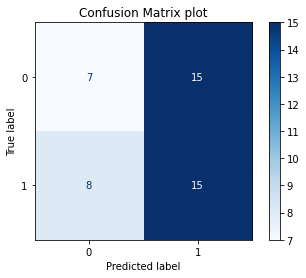

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report of SVM is: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.51      1.00      0.68        23

    accuracy                           0.51        45
   macro avg       0.26      0.50      0.34        45
weighted avg       0.26      0.51      0.35        45

Tuned Model Parameters of SVM:  {'C': 100, 'gamma': 0.001}
Best score of SVM: 0.5911764705882353
[[ 0 22]
 [ 0 23]]


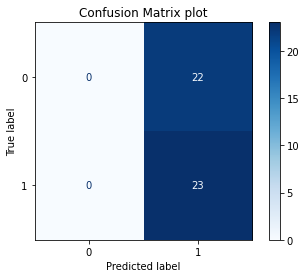

Classification report of multinomial naive bayes classifier is: 
               precision    recall  f1-score   support

           0       0.29      0.23      0.26        22
           1       0.39      0.48      0.43        23

    accuracy                           0.36        45
   macro avg       0.34      0.35      0.34        45
weighted avg       0.34      0.36      0.35        45

Tuned multinomial naive bayes Parameters: {'alpha': 1}
Best score with multinomial naive bayes classifier is 0.5826797385620915
[[ 5 17]
 [12 11]]


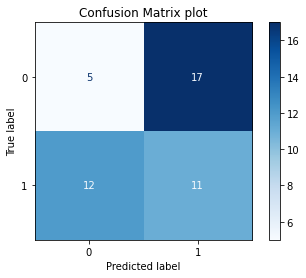

Classification report of Stochastic Gradient Descent classifier is: 
               precision    recall  f1-score   support

           0       0.47      0.41      0.44        22
           1       0.50      0.57      0.53        23

    accuracy                           0.49        45
   macro avg       0.49      0.49      0.48        45
weighted avg       0.49      0.49      0.49        45

Tuned Model Parameters of Stochastic Gradient Descent classifier:  {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
Best score of Stochastic Gradient Descent classifier: 0.607843137254902
[[ 9 13]
 [10 13]]


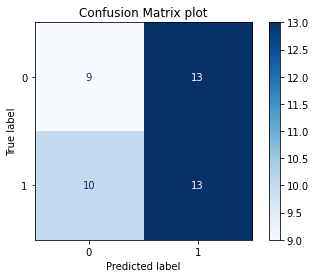

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report of random forest classifier is: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.51      1.00      0.68        23

    accuracy                           0.51        45
   macro avg       0.26      0.50      0.34        45
weighted avg       0.26      0.51      0.35        45

Tuned random forest classifier Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 7, 'n_estimators': 81}
Best score random forest classifier is 0.5908496732026143
[[ 0 22]
 [ 0 23]]


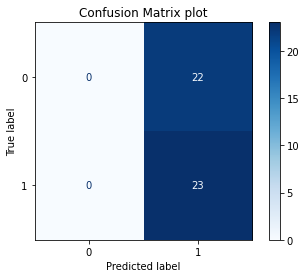

Classification report of AdaBoost is: 
               precision    recall  f1-score   support

           0       0.53      0.36      0.43        22
           1       0.53      0.70      0.60        23

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.52        45
weighted avg       0.53      0.53      0.52        45

Tuned Model Parameters of AdaBoost:  {'n_estimators': 38}
Best score of AdaBoost is 0.5624183006535947
[[ 8 14]
 [ 7 16]]


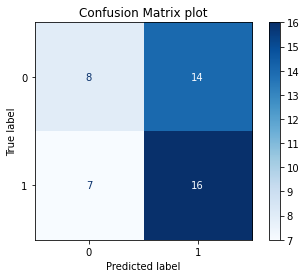

.........Vectorizing the headlines using vectorizer..........
Classification report of KNN is: 
               precision    recall  f1-score   support

           0       0.38      0.27      0.32        22
           1       0.45      0.57      0.50        23

    accuracy                           0.42        45
   macro avg       0.41      0.42      0.41        45
weighted avg       0.41      0.42      0.41        45

Best parameters of KNN: {'n_neighbors': 9}
Best score of KNN: 0.6019607843137255
[[ 6 16]
 [10 13]]


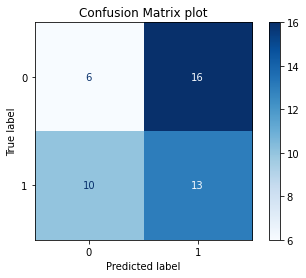

KeyboardInterrupt: ignored

In [9]:
 if __name__ == "__main__":

    # initialize the variables
    news_file_path = 'corona_news.csv'
    stocks_file_path = 'stock_prices_merged.csv'

    # call function and get data with combined headlines strings
    corona_news = combine_news_strings(news_file_path)

    # make a long string of all the headlines to find abbreviations
    combined_news = ' '.join(corona_news.News)

    # Call function to find abbreviations
    abbr_array = search_abbreviation(combined_news)    
    #np.set_printoptions(threshold=sys.maxsize) #for long output of abbreviations list
    print("Abbreviations present in the headlines are: \n", abbr_array)

    # do pre-processing of the headlines
    corona_news['News'] = corona_news['News'].apply(tokenize_and_preprocess_text)
    print(".............Text preprocessing is done..............")

    print("preprocessed headlines data: \n", corona_news.head(5))

    # merge headlines and stock prices data
    final_data = join_news_and_stocks_data(stocks_file_path)

    print("final data with headlines and stock market labels: \n", final_data.head(15)) 
    print("final data null values: ", final_data.isnull().sum())
    print("Summary statistics of final data: \n", final_data.describe())

    # get user input
    country = take_user_input()

    # validate the user input
    while country == None:
        print("Please enter a valid option")
        country = take_user_input()

    print(".................Classification started..................")

    # filter the data countrywise
    model_data = final_data[final_data['Country'] == country]
    print("Country-wise data: \n", model_data.head(5))
    print("Dimensions of country-wise data: ", model_data.shape)
    model_data = model_data.reset_index(drop=True)
    print("======================== Classifying stock market labels for", country, "============================")

    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(model_data['News'], model_data['Label'], test_size=0.2, random_state=42)        

    # vectorize and classify the data
    vectorize_and_classify(X_train, X_test, y_train, y_test)

    # vectorize data with word embedding and classify with LSTM
    word_embedding_LSTM(X_train, X_test, y_train, y_test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')